## Preprocessing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [ ]:
airbnb_data = pd.read_csv("listings 2.csv")
airbnb_data['price'] = airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)
airbnb_data = airbnb_data[airbnb_data['price'] != 99998]
columns_needed = [
    'id', 'name', 'neighborhood_overview', 'host_id', 'host_name', 'host_since',
    'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
    'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_identity_verified',
    'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
    'bathrooms_text', 'beds', 'price', 'number_of_reviews', 'number_of_reviews_ltm',
    'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating',
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'latitude', 'longitude', 'description', "host_about"
]

airbnb_data = airbnb_data[columns_needed]
airbnb_data['host_since'] = pd.to_datetime(airbnb_data['host_since'])
airbnb_data['year'] = airbnb_data['host_since'].dt.year

## Company VS Individual

In [ ]:
company_keywords = ['company', 'property', 'corporate']
company_listings_count_based = airbnb_data[
    (airbnb_data['host_listings_count'] > 10) |
    (airbnb_data['host_total_listings_count'] > 10)
]
company_keyword_mask = airbnb_data['host_about'].str.contains('|'.join(company_keywords), case=False, na=False)
company_listings_keyword_based = airbnb_data[company_keyword_mask]

company_listings = pd.concat([company_listings_count_based, company_listings_keyword_based]).drop_duplicates(subset='id')

company_unique_hosts = company_listings['host_id'].nunique()
company_total_listings = company_listings.shape[0]
company_average_listings_per_host = company_total_listings / company_unique_hosts

# Non-company listings
people_listings = airbnb_data[
    (airbnb_data['host_listings_count'] <= 10) &
    (airbnb_data['host_total_listings_count'] <= 10) &
    ~airbnb_data['id'].isin(company_listings['id'])
]
non_company_unique_hosts = people_listings['host_id'].nunique()
non_company_total_listings = people_listings.shape[0]
non_company_average_listings_per_host = non_company_total_listings / non_company_unique_hosts

(company_unique_hosts, company_total_listings, company_average_listings_per_host), (non_company_unique_hosts, non_company_total_listings, non_company_average_listings_per_host)


((368, 3621, 9.839673913043478), (3623, 5327, 1.4703284570797681))

## Super Host

In [ ]:
superhost_status_company = company_listings['host_is_superhost'].value_counts()
superhost_status_people = people_listings['host_is_superhost'].value_counts()

superhost_status_company, superhost_status_people

(host_is_superhost
 f    2327
 t    1265
 Name: count, dtype: int64,
 host_is_superhost
 f    2861
 t    2458
 Name: count, dtype: int64)

In [ ]:
company_superhost_metrics = company_listings.groupby('host_is_superhost').agg({
    'review_scores_rating': 'mean',
    'price': 'mean',
    'number_of_reviews': 'sum'
}).rename(index={'f': 'Non-Superhost', 't': 'Superhost'}, columns=lambda x: f"Company {x}")

people_superhost_metrics = people_listings.groupby('host_is_superhost').agg({
    'review_scores_rating': 'mean',
    'price': 'mean',
    'number_of_reviews': 'sum'
}).rename(index={'f': 'Non-Superhost', 't': 'Superhost'}, columns=lambda x: f"Individual {x}")

combined_metrics = pd.concat([company_superhost_metrics, people_superhost_metrics], axis=1)
combined_metrics

,Company review_scores_rating,Company price,Company number_of_reviews,Individual review_scores_rating,Individual price,Individual number_of_reviews
host_is_superhost,,,,,,
Non-Superhost,4.549636,155.787730,53231,4.700076,154.805372,104389
Superhost,4.853124,188.055466,58535,4.885233,160.488140,199614


## Region mapping processing

In [ ]:
airbnb_data = airbnb_data.dropna(subset=['neighbourhood_cleansed'])

unique_neighborhoods = airbnb_data['neighbourhood_cleansed'].unique()

neighborhood_summary = pd.DataFrame(unique_neighborhoods, columns=['Neighbourhood'])
neighborhood_summary.set_index('Neighbourhood', inplace=True)

neighborhood_summary['Total Listings'] = airbnb_data['neighbourhood_cleansed'].value_counts()
neighborhood_summary['Company Listings'] = company_listings['neighbourhood_cleansed'].value_counts().reindex(unique_neighborhoods, fill_value=0)
neighborhood_summary['People Listings'] = people_listings['neighbourhood_cleansed'].value_counts().reindex(unique_neighborhoods, fill_value=0)
neighborhood_summary['Superhost Listings'] = airbnb_data[airbnb_data['host_is_superhost'] == "t"]['neighbourhood_cleansed'].value_counts().reindex(unique_neighborhoods, fill_value=0)
neighborhood_summary['Non-Superhost Listings'] = airbnb_data[airbnb_data['host_is_superhost'] == "f"]['neighbourhood_cleansed'].value_counts().reindex(unique_neighborhoods, fill_value=0)
neighborhood_summary['Company Superhost'] = company_listings[company_listings['host_is_superhost'] == "t"]['neighbourhood_cleansed'].value_counts().reindex(unique_neighborhoods, fill_value=0)
neighborhood_summary['Company Non-Superhost'] = company_listings[company_listings['host_is_superhost'] == "f"]['neighbourhood_cleansed'].value_counts().reindex(unique_neighborhoods, fill_value=0)
neighborhood_summary['Individual Superhost'] = people_listings[people_listings['host_is_superhost'] == "t"]['neighbourhood_cleansed'].value_counts().reindex(unique_neighborhoods, fill_value=0)
neighborhood_summary['Individual Non-Superhost'] = people_listings[people_listings['host_is_superhost'] == "f"]['neighbourhood_cleansed'].value_counts().reindex(unique_neighborhoods, fill_value=0)

neighborhood_summary.reset_index(inplace=True)

In [ ]:
region_mapping = {
    'Rogers Park': 'Far North Side', 'West Ridge': 'Far North Side', 'Uptown': 'Far North Side',
    'Lincoln Square': 'Far North Side', 'Edison Park': 'Far North Side', 'Norwood Park': 'Far North Side',
    'Jefferson Park': 'Far North Side', 'Forest Glen': 'Far North Side', 'North Park': 'Far North Side',
    'Albany Park': 'Far North Side', 'O’Hare': 'Far North Side', 'Edgewater': 'Far North Side',
    'North Center': 'North Side', 'Lakeview': 'North Side', 'Lincoln Park': 'North Side',
    'Avondale': 'North Side', 'Logan Square': 'North Side', 'Portage Park': 'Northwest Side',
    'Irving Park': 'Northwest Side', 'Dunning': 'Northwest Side', 'Montclare': 'Northwest Side',
    'Belmont Cragin': 'Northwest Side', 'Hermosa': 'Northwest Side', 'Near North Side': 'Central',
    'Loop': 'Central', 'Near South Side': 'Central', 'Humboldt Park': 'West Side',
    'West Town': 'West Side', 'Austin': 'West Side', 'West Garfield Park': 'West Side',
    'East Garfield Park': 'West Side', 'Near West Side': 'West Side', 'North Lawndale': 'West Side',
    'South Lawndale': 'West Side', 'Lower West Side': 'West Side', 'Garfield Ridge': 'Southwest Side',
    'Archer Heights': 'Southwest Side', 'Brighton Park': 'Southwest Side', 'McKinley Park': 'Southwest Side',
    'New City': 'Southwest Side', 'West Elsdon': 'Southwest Side', 'Gage Park': 'Southwest Side',
    'Clearing': 'Southwest Side', 'West Lawn': 'Southwest Side', 'Chicago Lawn': 'Southwest Side',
    'West Englewood': 'Southwest Side', 'Englewood': 'Southwest Side', 'Armour Square': 'South Side',
    'Douglas': 'South Side', 'Oakland': 'South Side', 'Fuller Park': 'South Side',
    'Grand Boulevard': 'South Side', 'Kenwood': 'South Side', 'Washington Park': 'South Side',
    'Hyde Park': 'South Side', 'Woodlawn': 'South Side', 'South Shore': 'South Side',
    'Bridgeport': 'South Side', 'Greater Grand Crossing': 'South Side', 'Ashburn': 'Far Southwest Side',
    'Auburn Gresham': 'Far Southwest Side', 'Beverly': 'Far Southwest Side', 'Washington Heights': 'Far Southwest Side',
    'Mount Greenwood': 'Far Southwest Side', 'Morgan Park': 'Far Southwest Side', 'Chatham': 'Far South Side',
    'Avalon Park': 'Far South Side', 'South Chicago': 'Far South Side', 'Burnside': 'Far South Side',
    'Calumet Heights': 'Far South Side', 'Roseland': 'Far South Side', 'Pullman': 'Far South Side',
    'South Deering': 'Far South Side', 'East Side': 'Far South Side', 'West Pullman': 'Far South Side',
    'Riverdale': 'Far South Side', 'Hegewisch': 'Far South Side'
}

neighborhood_summary['Region'] = neighborhood_summary['Neighbourhood'].map(region_mapping)

In [ ]:
region_summary = neighborhood_summary.groupby('Region').agg({
    'Total Listings': 'sum',
    'Company Listings': 'sum',
    'People Listings': 'sum',
    'Superhost Listings': 'sum',
    'Non-Superhost Listings': 'sum',
    '(Company Superhost': 'sum',
    'Company Non-Superhost': 'sum',
    'Individual Superhost': 'sum',
    'Individual Non-Superhost)': 'sum'
}).reset_index()

## Regonal visualization


### Regional percentage

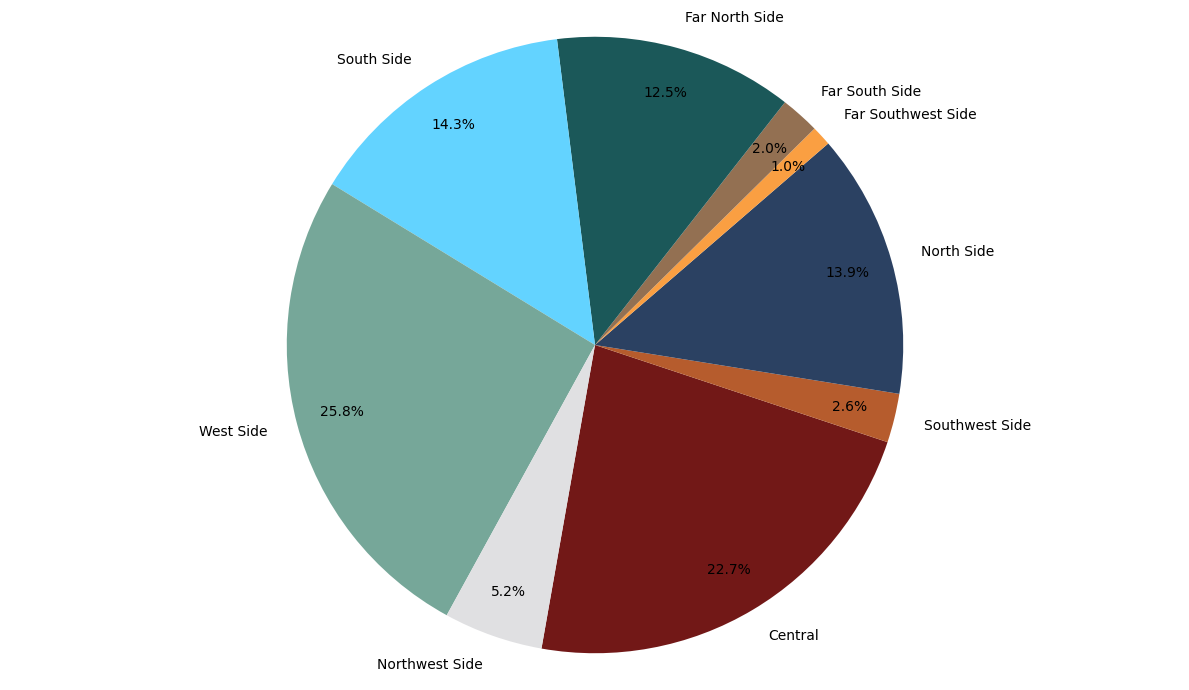

In [ ]:
custom_order = ['Central', 'Southwest Side', 'North Side', 'Far Southwest Side',
                'Far South Side', 'Far North Side', 'South Side', 'West Side', 'Northwest Side']
region_summary['Region'] = pd.Categorical(region_summary['Region'], categories=custom_order, ordered=True)
region_summary = region_summary.sort_values('Region')

colors = ['#721817','#B65C2D','#2B4162', '#FA9F42','#937052', '#1B5859', '#63D3FF', '#76A799', '#E0E0E2']

plt.figure(figsize=(12, 7))
wedges, texts, autotexts = plt.pie(region_summary['Total Listings'], labels=region_summary['Region'],
                                   autopct='%1.1f%%', startangle=260, colors=colors, pctdistance=0.85)

plt.axis('equal')
# plt.title('Distribution of Total Listings by Region')
plt.tight_layout()
plt.show()

### Company & Individual regional listing

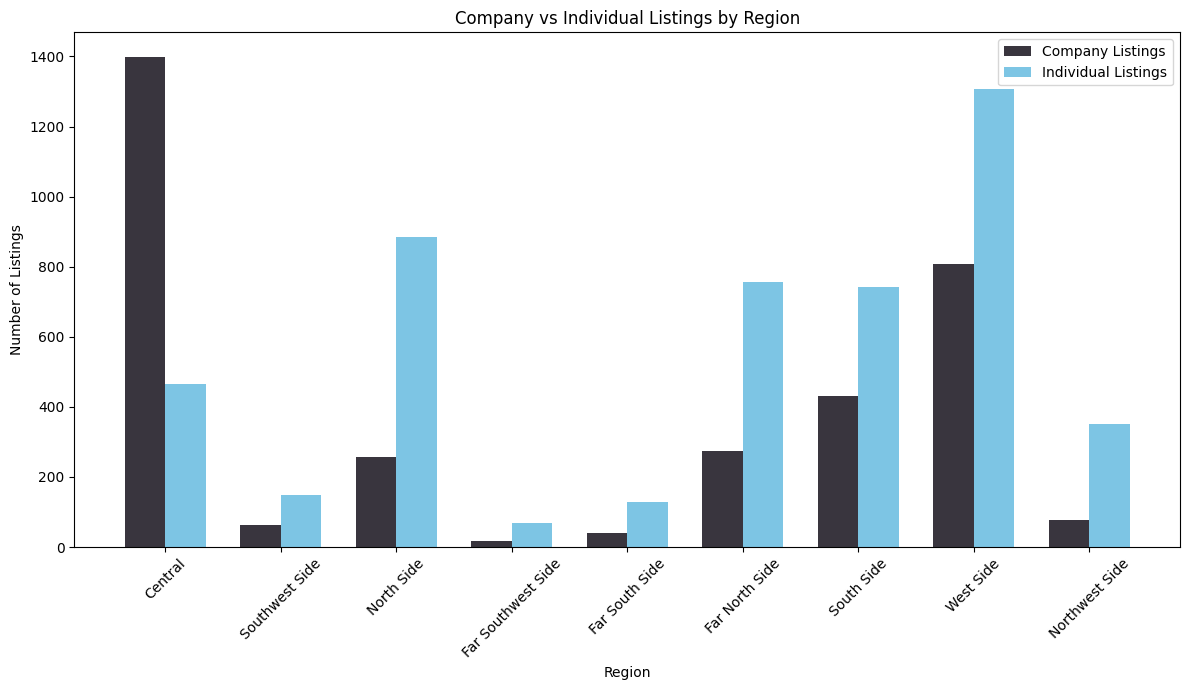

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
index = range(len(region_summary['Region']))
bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(index, region_summary['Company Listings'], bar_width,
                alpha=opacity, color='#07020D', label='Company Listings')

rects2 = ax.bar([p + bar_width for p in index], region_summary['People Listings'], bar_width,
                alpha=opacity, color='#5DB7DE', label='Individual Listings')

ax.set_xlabel('Region')
ax.set_ylabel('Number of Listings')
ax.set_title('Company vs Individual Listings by Region')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(region_summary['Region'])
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Stacked regional company vs individual

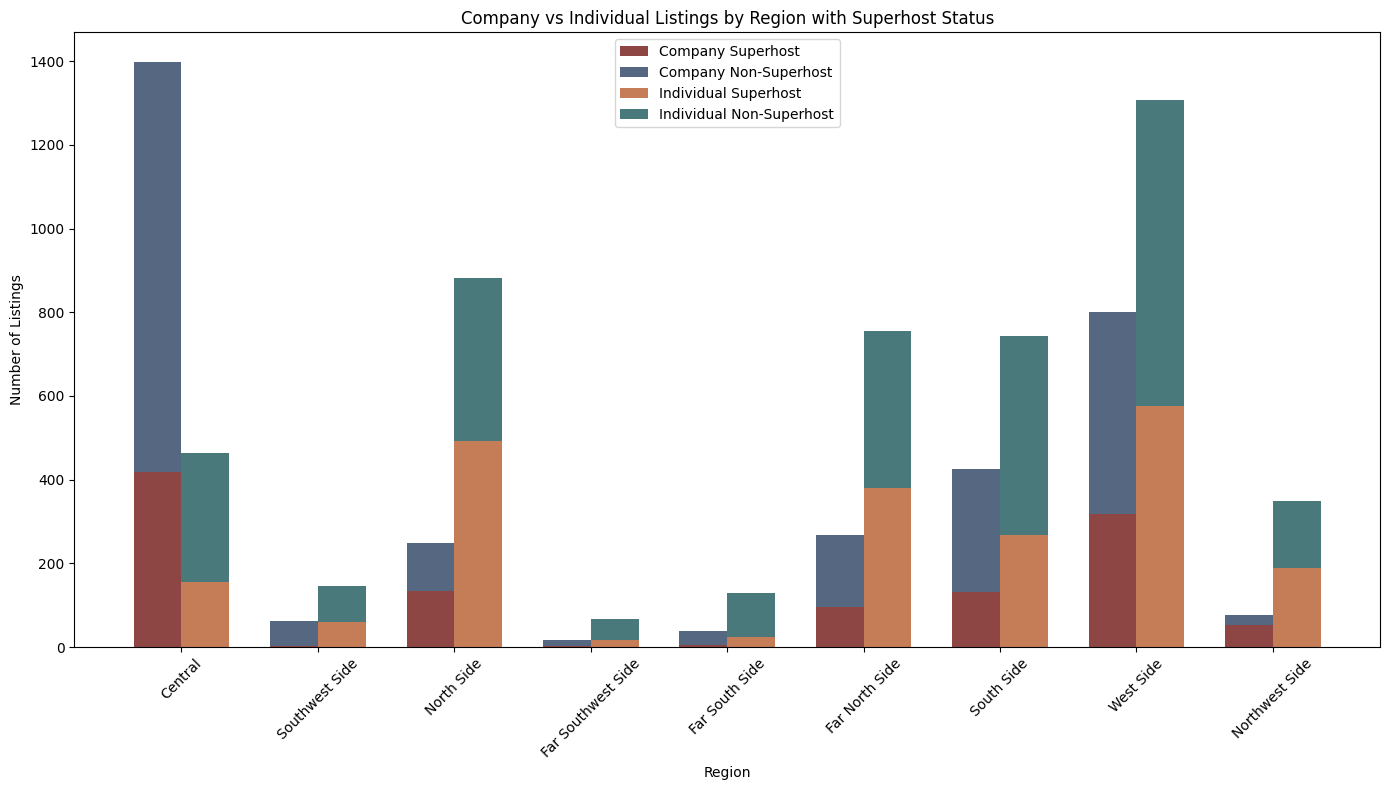

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
index = range(len(region_summary['Region']))
bar_width = 0.35
opacity = 0.8

company_superhost = ax.bar(index, region_summary['Company Superhost'], bar_width,
                           alpha=opacity, color='#721817', label='Company Superhost')

company_non_superhost = ax.bar(index, region_summary['Company Non-Superhost'], bar_width,
                               alpha=opacity, color='#2B4162', bottom=region_summary['Company Superhost'],
                               label='Company Non-Superhost')

individual_superhost = ax.bar([p + bar_width for p in index], region_summary['Individual Superhost'], bar_width,
                              alpha=opacity, color='#B65C2D', label='Individual Superhost')

individual_non_superhost = ax.bar([p + bar_width for p in index], region_summary['Individual Non-Superhost'], bar_width,
                                  alpha=opacity, color='#1B5859', bottom=region_summary['Individual Superhost'],
                                  label='Individual Non-Superhost')

ax.set_xlabel('Region')
ax.set_ylabel('Number of Listings')
ax.set_title('Company vs Individual Listings by Region with Superhost Status')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(region_summary['Region'])
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Chicago map visualization

In [ ]:
gdf = gpd.read_file('geo_export_33ca7ae0-c469-46ed-84da-cc7587ccbfe6.shp')
listings = pd.read_csv('listings 2.csv')
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)
listings = listings[listings['price'] != 99998]
listings['neighbourhood_cleansed'] = listings['neighbourhood_cleansed'].str.upper()

listings_summary = listings.groupby('neighbourhood_cleansed').size().reset_index(name='count')

gdf_communities = set(gdf['community'].unique())
airbnb_communities = set(listings['neighbourhood_cleansed'].unique())

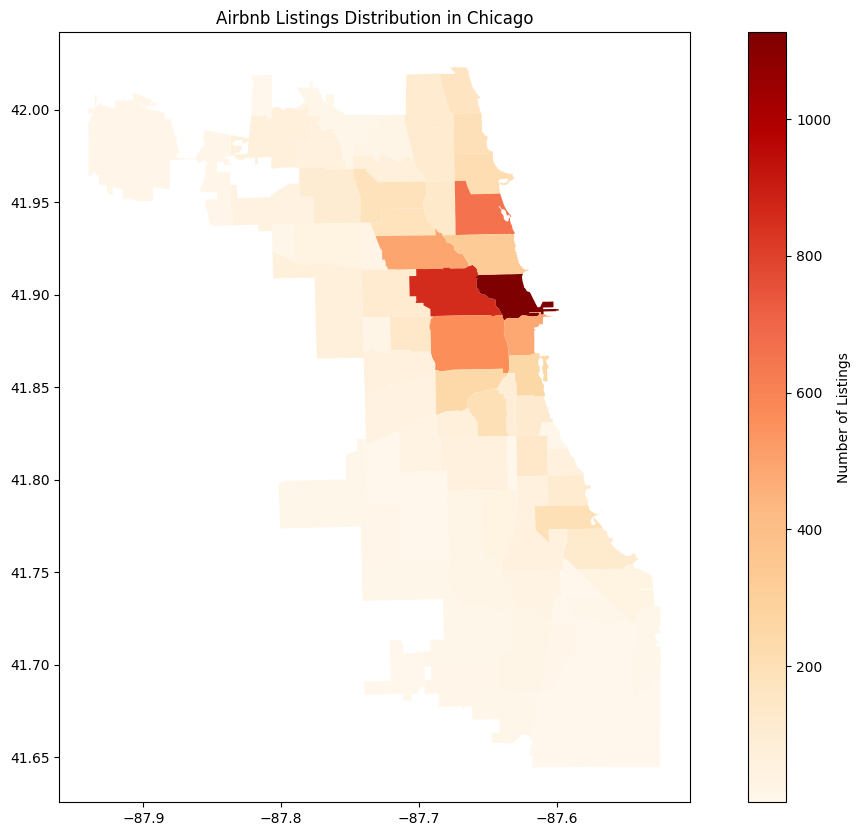

In [ ]:
gdf = gdf.merge(listings_summary, left_on='community', right_on='neighbourhood_cleansed', how='left')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='count', ax=ax, legend=True,
         legend_kwds={'label': "Number of Listings"},
         cmap='OrRd',  # Colormap for orange to red spectrum
         missing_kwds={'color': 'lightgrey'})

plt.title('Airbnb Listings Distribution in Chicago')
plt.show()

In [ ]:
gdf['community'] = gdf['community'].str.upper()

# Aggregate Company Listings by Neighborhood
company_listings['neighbourhood_cleansed'] = company_listings['neighbourhood_cleansed'].str.upper()
company_summary = company_listings.groupby('neighbourhood_cleansed').size().reset_index(name='company_count')

# Aggregate Individual Listings by Neighborhood
people_listings['neighbourhood_cleansed'] = people_listings['neighbourhood_cleansed'].str.upper()
people_summary = people_listings.groupby('neighbourhood_cleansed').size().reset_index(name='people_count')

gdf = gdf.merge(company_summary, how='left', left_on='community', right_on='neighbourhood_cleansed')
gdf = gdf.merge(people_summary, how='left', left_on='community', right_on='neighbourhood_cleansed')

gdf['company_count'].fillna(0, inplace=True)
gdf['people_count'].fillna(0, inplace=True)

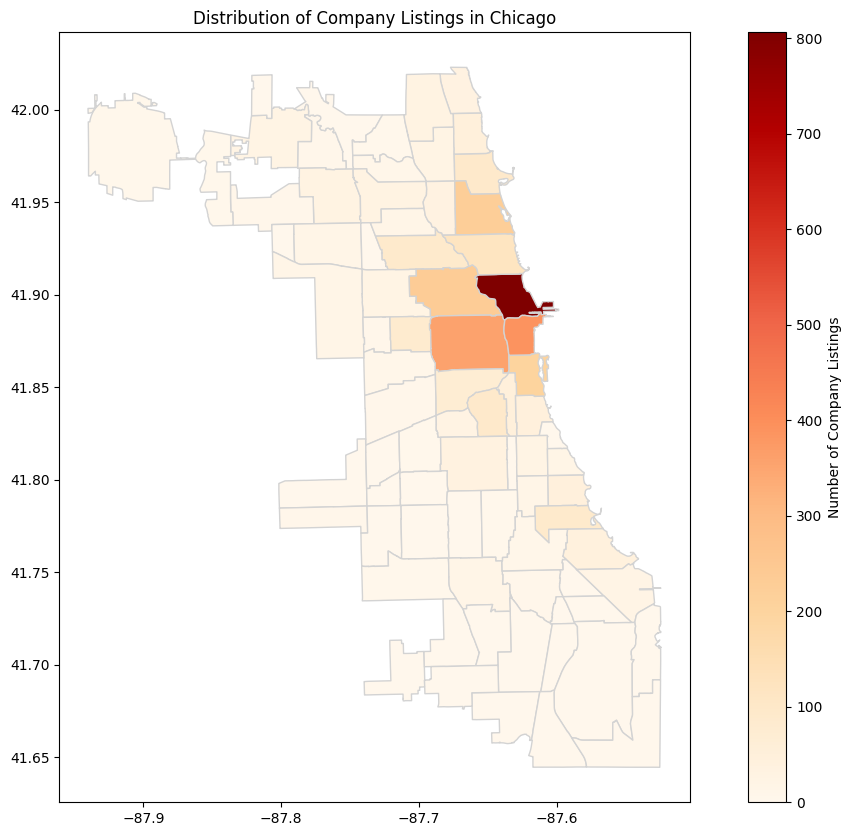

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='company_count', ax=ax, legend=True,
         legend_kwds={'label': "Number of Company Listings"},
         cmap='OrRd', edgecolor='lightgrey',
         missing_kwds={'color': 'lightgrey'})
plt.title('Distribution of Company Listings in Chicago')
plt.show()

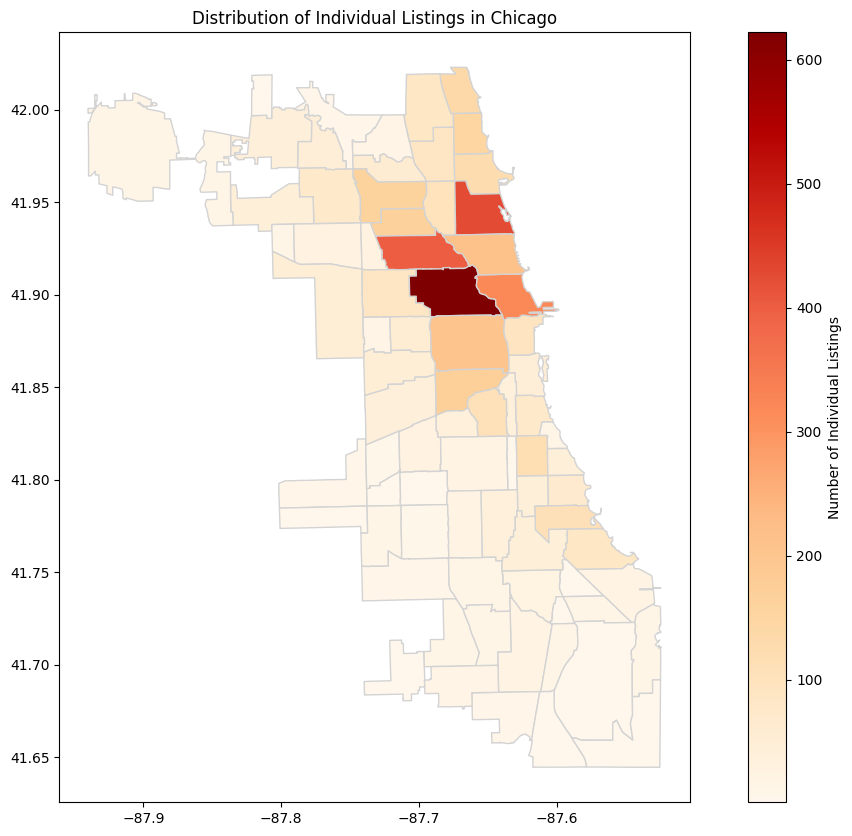

In [ ]:
# Plot for Individual Listings
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='people_count', ax=ax, legend=True,
         legend_kwds={'label': "Number of Individual Listings"},
         cmap='OrRd', edgecolor='lightgrey',
         missing_kwds={'color': 'lightgrey'})
plt.title('Distribution of Individual Listings in Chicago')
plt.show()

## Price map

In [ ]:
airbnb_data['neighbourhood_cleansed'] = airbnb_data['neighbourhood_cleansed'].str.upper()
airbnb_data.loc[airbnb_data['neighbourhood_cleansed'] == 'CLEARING', 'price'] = 222
price_summary = airbnb_data.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
price_summary.columns = ['neighbourhood_cleansed', 'median_price']

gdf = gdf.merge(price_summary, how='left', left_on='community', right_on='neighbourhood_cleansed')

gdf['median_price'].fillna(0, inplace=True)

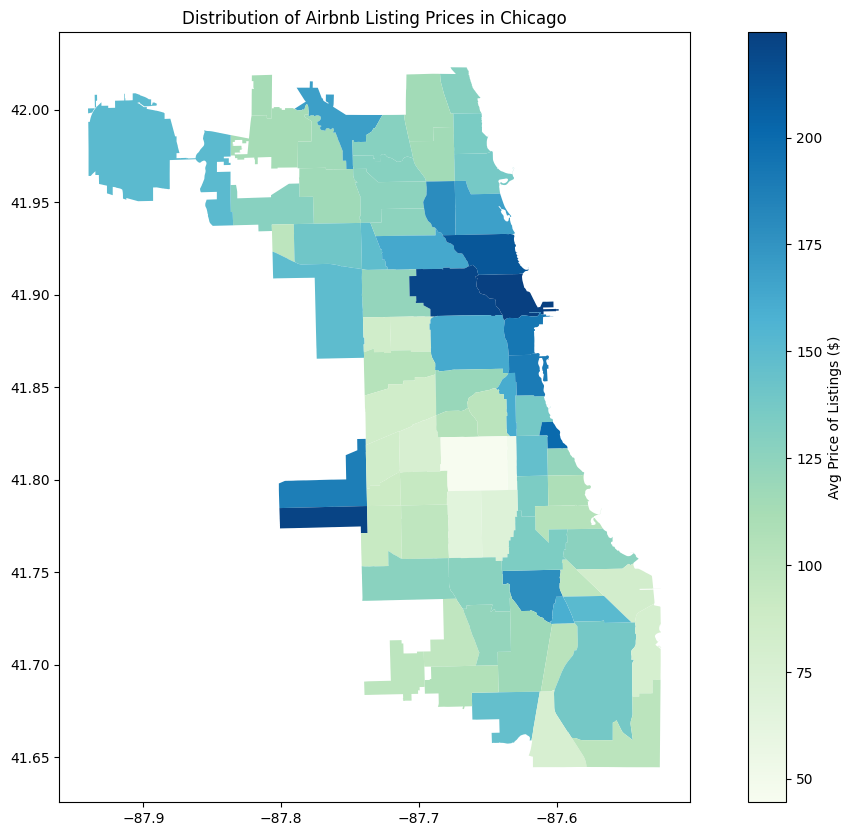

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
price_map = gdf.plot(column='median_price', ax=ax, legend=True,
                     legend_kwds={'label': "Avg Price of Listings ($)"},
                     cmap='GnBu', #edgecolor='black',
                     missing_kwds={'color': 'lightgrey'})
plt.title('Distribution of Airbnb Listing Prices in Chicago')
plt.show()